# Import Libraries and Tools



In [4]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance
from sklearn.utils import shuffle

# keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16



### Load Datasets

In [5]:
# Directories for training and testing data
train_dir = '/content/drive/MyDrive/Img mri/Training'
test_dir = '/content/drive/MyDrive/Img mri/Testing'

# Load and shuffle train data
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle test data
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

### Image Preprocessing

In [6]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = np.array(image) / 255.0
    return image


# Load Images and Apply Augmentation
IMAGE_SIZE = 128

def open_images(paths):
    images = []
    for path in paths:
        img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        img = np.array(img)
        img = augment_image(img)
        images.append(img)
    return np.array(images)


# Encode Labels (names to integers)
def encode_label(labels):
    unique_labels = sorted(os.listdir(train_dir))
    label_map = {label: idx for idx, label in enumerate(unique_labels)}
    return [label_map[label] for label in labels]

# Data Generator for Batching
def datagen(paths, labels, batch_size=12, epochs=1):
    encoded_labels = encode_label(labels)
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_labels = encoded_labels[i:i + batch_size]
            batch_images = open_images(batch_paths)
            yield batch_images, np.array(batch_labels)



## Model

In [7]:
os.listdir(train_dir)

['pituitary', 'glioma', 'notumor', 'meningioma']

In [9]:
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Build Model
model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),  # Input layer
    base_model,  # VGG16
    Flatten(),  # Flatten layer
    Dropout(0.3),  # Dropout layer (to avoid overfitting)
    Dense(128, activation='relu'),  # Dense layer
    Dropout(0.2),  # Dropout layer
    Dense(len(os.listdir(train_dir)), activation='softmax')  # Output layer
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)
epochs = 5

# Train model
history = model.fit(
    datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
    epochs=epochs,
    steps_per_epoch=steps
)


Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1206s 4s/step - loss: 0.6656 - sparse_categorical_accuracy: 0.7266
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1198s 4s/step - loss: 0.2583 - sparse_categorical_accuracy: 0.9022
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1199s 4s/step - loss: 0.2022 - sparse_categorical_accuracy: 0.9242
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1196s 4s/step - loss: 0.1374 - sparse_categorical_accuracy: 0.9470
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1195s 4s/step - loss: 0.0970 - sparse_categorical_accuracy: 0.9704


## Train and Val Plots

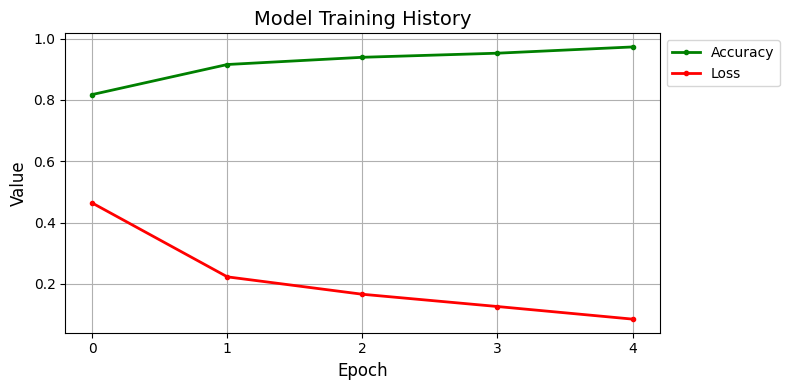

In [10]:
import matplotlib.pyplot as plt

# Plot Training History
plt.figure(figsize=(8, 4))
plt.grid(True)

# Accuracy plot
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2, label='Accuracy')

# Loss plot
plt.plot(history.history['loss'], '.r-', linewidth=2, label='Loss')

# Adding title and labels
plt.title('Model Training History', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Value', fontsize=12)

# Ensure proper ticks on x-axis
plt.xticks(range(epochs), fontsize=10)

# Add legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()



# Model Classification Report

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load test images and labels
test_images = open_images(test_paths)
test_labels_encoded = encode_label(test_labels)

# Predict on test images
test_predictions = model.predict(test_images)

# Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)






41/41 ━━━━━━━━━━━━━━━━━━━━ 232s 6s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       300
           1       0.95      0.88      0.92       306
           2       0.99      0.99      0.99       405
           3       0.97      0.98      0.97       300

    accuracy                           0.96      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.96      0.96      0.96      1311

Confusion Matrix:
[[288  10   2   0]
 [ 24 270   2  10]
 [  2   1 402   0]
 [  3   2   2 293]]


## Model Confusion Plot

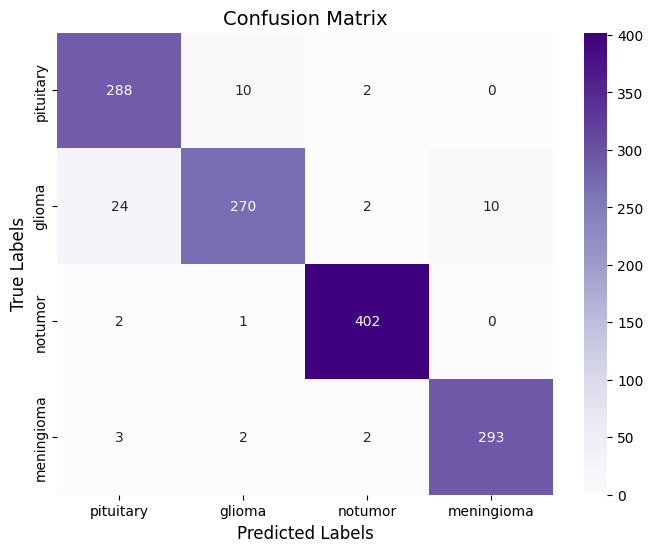

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.show()

## Roc Curve Plot

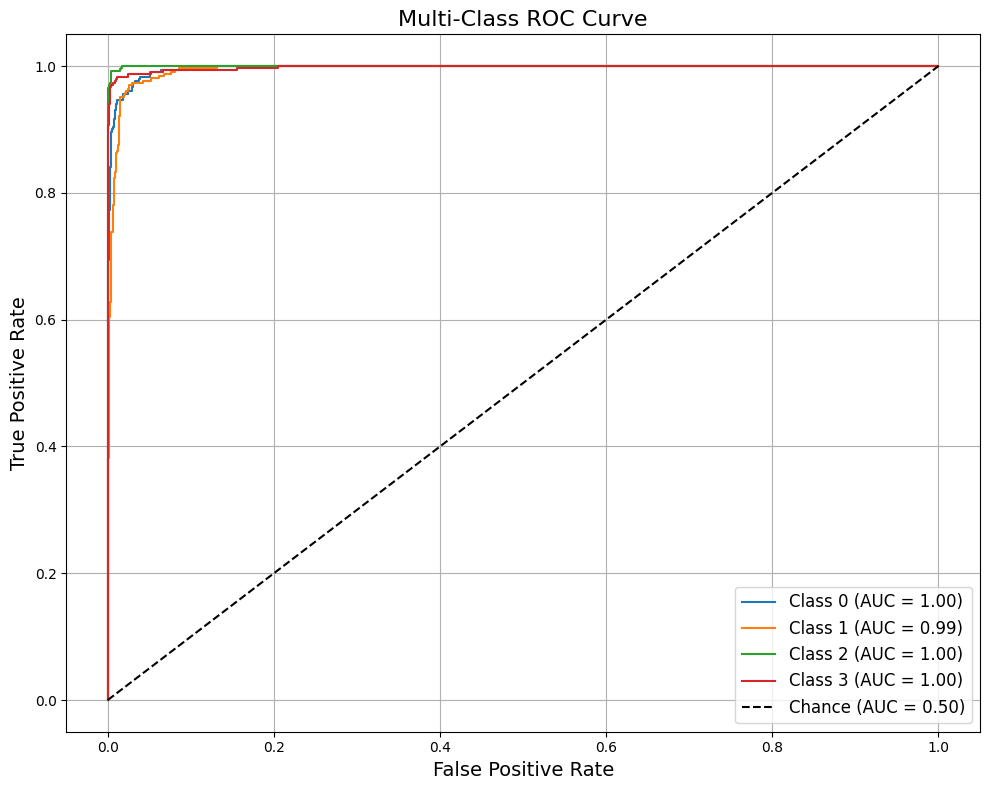

In [15]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the labels for multi-class ROC curve
num_classes = len(os.listdir(train_dir))  # Number of classes
test_labels_binarized = label_binarize(test_labels_encoded, classes=range(num_classes))

# Calculate ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_binarized[:, i], test_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot a diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')

# Add labels, title, and legend
plt.title('Multi-Class ROC Curve', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


## Save and Load Model

In [16]:
model.save('model.h5')

In [17]:
from tensorflow.keras.models import load_model
# load the trained model
model = load_model('model.h5')

In [18]:
model.save('model.h5')  # Saves your trained model as 'model.h5'


# App.py

In [20]:
%%writefile app.py
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import os

# Load the trained model
model = load_model('model.h5')  # Ensure your model file is in the same directory
IMAGE_SIZE = 128

# Define class labels
class_names = ['Class1', 'Class2', 'Class3']  # Replace with actual class names

# Function to preprocess the image and make predictions
def predict(image):
    image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    predictions = model.predict(image)
    prediction_dict = {class_names[i]: float(predictions[0][i]) for i in range(len(class_names))}
    return prediction_dict

# Gradio interface
interface = gr.Interface(
    fn=predict,
    inputs=gr.inputs.Image(type="pil"),
    outputs=gr.outputs.Label(num_top_classes=3),
    title="MRI Image Classifier",
    description="Upload an MRI image to classify it.",
)

if __name__ == "__main__":
    interface.launch()


Writing app.py


In [21]:
%%writefile requirements.txt
tensorflow==2.13.0
gradio==3.34.0
numpy
Pillow


Writing requirements.txt
